### 选择预训练模型

将深度学习应用于小型图像数据集，一种常用且非常高效的方法是使用预训练网络。  
**预训练网络（pretrained network）**是一个保存好的网络，之前已在大型数据集（通常是大规模图
像分类任务）上训练好。这个方法也叫**迁移学习**。

- 预训练的模型学到的特征的空间层次结构可以有效地作为视觉世界的通用模型
- 较低层学到的结构都是一些点线等低层次的特征，

这里使用的预训练的模型的数据是 ImageNet 数据集（140 万张标记图像，1000 个不同的类别），为了降低理解的难度使用VGG16架构来获取预训练的模型。它是一种简单而又广泛使用的卷积神经网络架构。其实还有很多架构例如：
- VGG
- ResNet
- Inception
- Inception-ResNet
- Xception



### 预训练模型的特征提取

特征提取是使用之前网络学到的表示来从新样本中提取出有用的特征。然后将这些特征输入一个新的分类器，从头开始训练。

#### 卷积基

对于分类的卷积神经网络基本包含两个主要组成：
- 一系列池化层和卷积层 **卷积基**
- 一个密集连接分类器

特征提取就是取出之前训练好的网络的卷积基，在上面运行新数据，然后在输出上面训练一个新的分类器
具体如下图:

![卷积基](imgs/10.jpg)

#### 卷积基复用性

- 卷积基学到的表示可能更加通用，因此更适合重复使用
- 特征图表示通用概念在图像中是否存在
- 特征图表示输入图像中的位置信息

使用预训练模型的时候需要注意：
- 低层学到的结构都是一些点线等低层次的特征（比如视觉边缘、颜色和纹理）
- 靠近顶部的层提取的是更加抽象的概念（猫的眼睛，狗的鼻子）

**如果新的数据集与预训练的数据集差异很大，那么最好只使用前几层来做特征提取**


#### keras内置的模型
keras.applications 中的一部分图像分类模型,都是在 ImageNet 数据集上预训练得到：

- VGG16
- VGG19
- ResNet50
- Inception V3
- MobileNet

具体的使用如下函数,参数如下 

- `weights:` 指定模型初始化的权重检查点
- `include_top:`指定模型最后是否包含密集连接分类器,
- `input_shape`: 是输入到网络中的图像张量的形状


In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
               include_top = False,
               input_shape=(150,150,3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

VGG16的模型架构非常的常见，如上面所示。最后的特征图的反馈的是(4,4,512).目前有两种方式来使用VGG16的卷积基。
- 独立使用卷积基：就是先将输入数据再卷积基上运行一次，然后将结果作为输入，再放到独立的Dense网络中计算训练一个dense 网络。
    - 速度快，计算代价低，因为每个输入图像只需运行一次卷积基
    - 但是无法做数据扩增，容易过拟合
    - 对于电脑配置不高的可以使用该方法
    
- 将卷积基放到整个模型中，直接使用数据输入端到端的运行整个模型
    - 计算量大，需要电脑的配置较高，一定要有GPU的加持
    - 可以使用数据增强来训练模型，
    
### 独立使用卷积基的快速特征提取

- 利用conv_base  predict 方法从模型中的使用预训练的卷积基提取特征
- 提取的特征形状为，并将将其展平成密集连接分类器的数据
- 定义自己的密集连接分类器

从图中可以看到验证精度达到了约 90%，比上一节从头开始训练的小型模型效果要好得多。但从图中也可以看出，虽然 dropout 比率相当大，但模型几乎从一开始就过拟合。


In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = "G:/Data/Kaggle/dogcat/smallData"
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')


In [4]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory,sample_count):
    features = np.zeros(shape=(sample_count,4,4,512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    
    i = 0
    for inputs_batch,labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features,labels

train_features,train_labels = extract_features(train_dir,2000)
validation_features,validation_labels = extract_features(validation_dir,1000)
test_features,test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
#其形状展平为 

print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)
train_features = np.reshape(train_features,(2000,4*4*512))
validation_features = np.reshape(validation_features,(1000,4*4*512))

test_features = np.reshape(test_features,(1000,4*4*512))

print(test_features.shape)

(1000, 8192)


In [15]:
# 定义并训练密集连接分类器

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256,activation='relu',input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr = 2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])


In [17]:
history = model.fit(train_features, train_labels, 
                    epochs=30, 
                    batch_size=20, 
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 764us/step - loss: 0.6043 - acc: 0.6650 - val_loss: 0.4369 - val_acc: 0.8600
Epoch 2/30
2000/2000 [==============================] - 1s 348us/step - loss: 0.4321 - acc: 0.8055 - val_loss: 0.3604 - val_acc: 0.8730
Epoch 3/30
2000/2000 [==============================] - 1s 349us/step - loss: 0.3655 - acc: 0.8365 - val_loss: 0.3236 - val_acc: 0.8810
Epoch 4/30
2000/2000 [==============================] - 1s 353us/step - loss: 0.3300 - acc: 0.8580 - val_loss: 0.2945 - val_acc: 0.8880
Epoch 5/30
2000/2000 [==============================] - 1s 347us/step - loss: 0.2928 - acc: 0.8780 - val_loss: 0.2853 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 1s 365us/step - loss: 0.2712 - acc: 0.8945 - val_loss: 0.2663 - val_acc: 0.8920
Epoch 7/30
2000/2000 [==============================] - 1s 353us/step - loss: 0.2539 - a

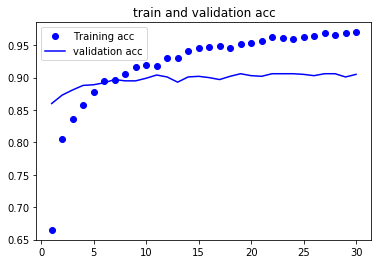

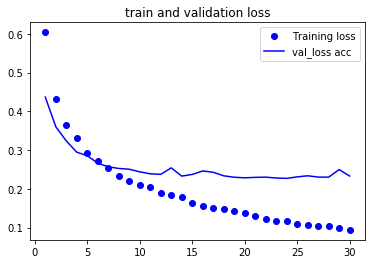

In [20]:
# 　绘制训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) +1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='validation acc')
plt.title('train and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='val_loss acc')
plt.title('train and validation loss')
plt.legend()

plt.show()

###  联合卷积基进行特征提取

模型的行为和层类似，所以你可以向 Sequential 模型中添加一个模型,具体模型如下：

VGG16 的卷积基有 14 714 688 个参数，非常多。在其上添加的分类器有 200 万个参数.如此多的参数都是预先定义好的
所以这里再训练的时候不需要重新再训练一遍：在编译和训练模型之前，一定要“冻结”卷积基。
**冻结（freeze）** 一个或多个层是指在训练过程中保持其权重不变。



In [4]:
#在卷积基上添加一个密集连接分类器
from keras import models
from keras import layers

model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dense(1,activation = 'sigmoid'))


In [5]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


#### keras冻结网络层的方法

冻结网络的方法是将其 trainable 属性设为 False，如此设置之后，只有添加的两个 Dense 层的权重才会被训练。总共有 4 个权重张量，每层 2 个（主权重矩阵和偏置向量）。
*注意，为了让这些修改生效，你必须先编译模型。如果在编译之后修改了权重的 trainable 属性，那么应该重新编译模型，否则这些修改将被忽略。


In [6]:
#conv_base.trainable = True
print('This is the number of trainable weights ' 
         'before freezing the conv base:', len(model2.trainable_weights)) 
conv_base.trainable = False
print('This is the number of trainable weights ' 
         'after freezing the conv base:', len(model2.trainable_weights)) 

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size = 20,
    class_mode='binary'
)

model2.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr = 2e-5),
             metrics=['acc'])

history = model2.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 40s 401ms/step - loss: 0.5962 - acc: 0.6865 - val_loss: 0.4680 - val_acc: 0.8110
Epoch 2/30
100/100 [==============================] - 17s 168ms/step - loss: 0.5005 - acc: 0.7685 - val_loss: 0.3766 - val_acc: 0.8640
Epoch 3/30
100/100 [==============================] - 17s 168ms/step - loss: 0.4510 - acc: 0.7900 - val_loss: 0.3304 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 17s 172ms/step - loss: 0.4034 - acc: 0.8310 - val_loss: 0.3070 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3961 - acc: 0.8180 - val_loss: 0.3013 - val_acc: 0.8860
Epoch 6/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3818 - acc: 0.8360 - val_loss: 0.3010 - val_acc: 0.8790
Epoch 7/30
100/100 [==============================] - 17s 

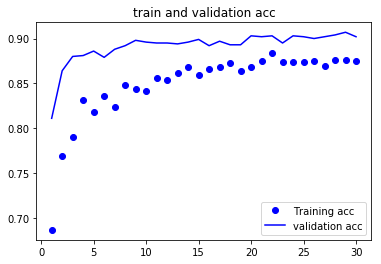

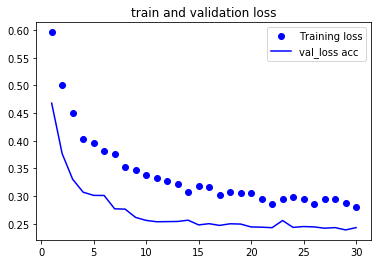

In [9]:
# 　绘制训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc) +1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='validation acc')
plt.title('train and validation acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='val_loss acc')
plt.title('train and validation loss')
plt.legend()

plt.show()